In [1]:
%matplotlib notebook
from pathlib import Path
import cartopy.crs as ccrs
import xarray as xr
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
from scipy import stats
import statsmodels.api as sm
import datetime 
from statsmodels.formula.api import ols
import math
import statistics
from numpy import*
import pandas as pd
import numpy as np
import statsmodels.api as sm
from datetime import datetime
from netCDF4 import Dataset

In [114]:
file=Path(r"D:\Datasets\XTRACK\ESACCI-SEALEVEL-L3-SLA-N_INDIAN-MERGED-20200113-JA-218-fv01.1.nc")
ds=xr.open_dataset(file,decode_times=False)

In [22]:
def select_point(ds,point,verbose=True):
    ''' select a point in a track and return a dict with needed parameters'''
    #ref=pd.Timestamp(1950,1,1)
    
    output={}
    if verbose :
        print(f"extract point #{point} on track {ds.pass_number}")
    output["dist"]=ds.dist_to_coast_gshhs[point].values/1000.
    output['pt']=point
    output["location"]=[ds.lon[point].values,ds.lat[point].values]
    #time = pd.to_datetime(ds.time[point,:], unit='D', origin=ref)
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    output["ts"]=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    output["valid"] = (1-(output['ts'].isna().sum().values[0] / len(output['ts'])))*100.
    #output["trend"],intercept,std_error= trend_ols(sla.values,ds.time[point,:].values)
    #output['trend_rate_with_outlier']=output["trend"]*1000*365
    output['flagged']=sigma_mask(output['ts'])
    output['Trend_rate']=flagged_trend(ds,point)
    df_flagged=output['flagged']
    slope,intercept,std_error=trend_ols(df_flagged.values,df_flagged.index.values)
    output['dataframe']=pd.DataFrame(index={point},data={'lat':ds.lat[point].values,
                                                        'lon':ds.lon[point].values,
                                                        'Valid': output["valid"],
                                                        'Trend':slope*1000*365,
                                                        'Std Error':std_error*1000*365,
                                                        'Intercept':intercept*1000*365,
                                                        'Offshore': output["dist"]})
    return output

def sigma_mask(df,n=2):
    '''''''removing outliers'''
    sigma = df.std()
    mask = (df >- n*sigma) & (df < n*sigma)
    df_masked=df[mask.values]
    return df_masked

def flagged_trend(ds,point):
    
    time = ds.time[point,:]
    sla  = ds.sla[point,:]
    df=pd.DataFrame(index=time,data={ds['sla'].attrs['long_name']:sla})
    df_masked=sigma_mask(df,n=2)
    slope,intercept,std_error=trend_ols(df_masked.values,df_masked.index.values)
    trend_rate=slope*1000*365
    #print ('trend rate is :',(trend_rate),'mm/yr' )


def plot_point(ds,point):
    '''ploting points without outliers'''
    ref=pd.Timestamp(1950,1,1)
    output=select_point(ds,point)
    title=f"Point No: {point} - Distance to Coast: {output['dist']:.2f} km-{output['valid']:.2f}%"
    df=output['ts']
    df_flagged=output['flagged']
    time=pd.to_datetime(output['ts'].index, unit='D', origin=ref)
    time_flagged=pd.to_datetime(output['flagged'].index, unit='D', origin=ref)

    #plots
    fig,ax=plt.subplots()
    figsize=(20,20)
    ax.scatter(time,df.values,color='red')
    ax.plot(time_flagged,df_flagged.values,color='skyblue')
    slope,intercept,std_error=trend_ols(df_flagged.values,df_flagged.index.values)
    s_mm=slope*1000*365
    s_mm="%.2f" % s_mm
    e_mm=std_error*1000*365
    e_mm="%.2f" % e_mm
    label=f"{s_mm} mm/yr +/- {e_mm} mm/yr"
    y_fit=  slope*df_flagged.index.values+intercept
    ax.plot(time_flagged,y_fit,linewidth=2.,c='green',label=label)
    ax.set_yticks(np.arange(-0.5, 1, 0.5))
    ax.set_title(title)
    ax.legend(loc=1)
    plt.ylabel("Sea Level Anomaly (m)")
    plt.grid()
    return ax

def trend_ols(y,x,summary=False,verbose=False):
    ''' '''
    model=sm.OLS(y,sm.add_constant(x),missing='drop')
    results=model.fit()
    intercept,slope = results.params
    std_error=results.bse[1]
    y_fit=  slope*x+intercept
    if summary :
        print(results.summary())
    else :
        if verbose :
            print(f"the slope is {slope}")
            print (f"the standard error is {results.bse[1]}")
        #print ('trend rate is :',(trend_rate),'mm/yr' )
    return slope,intercept,std_error

def map_selected_point(ds,point,extent=None):
    dl=1.
    if extent is None :
        extent = [ds.lon.min()-dl, ds.lon.max()+dl, ds.lat.min()-dl, ds.lat.max()+dl]
    fig=plt.figure(figsize=(5,5))
    ax=plt.axes(projection=ccrs.PlateCarree())
    ax.set_extent(extent, ccrs.PlateCarree())
    ax.coastlines(resolution='10m') 
    ax.gridlines(draw_labels=True)
    ax.scatter(ds.lon.values,ds.lat.values,color='black',marker='.')
    ax.scatter(ds.lon[point].values,ds.lat[point].values,color='red',marker='o',zorder=1)
    return ax

In [116]:
d=select_point(ds,0,verbose=False)

In [117]:
d['dataframe']

,lat,lon,Valid,Trend,Std Error,Intercept,Offshore
0,0.00066,84.334366,23.05141,6.857205,1.716886,-146623.387972,762.083313


In [118]:
df0=pd.DataFrame()
for i in ds.nbpoints.values:
    d=select_point(ds,i,verbose=False)
    df0=df0.append(d['dataframe'],ignore_index=True)

In [119]:
df0

,lat,lon,Valid,Trend,Std Error,Intercept,Offshore
0,0.000660,84.334366,23.051410,6.857205,1.716886,-146623.387972,762.083313
1,0.002592,84.333969,45.771144,4.912449,1.183673,-104817.146747,761.871953
2,0.005210,84.332985,51.077944,4.226306,1.202447,-88544.364620,761.563773
3,0.007818,84.332214,59.701493,3.887386,1.144115,-82984.589449,761.267033
4,0.010428,84.331322,72.470978,3.763342,0.920201,-81699.278014,760.964083
...,...,...,...,...,...,...,...
3916,12.096672,79.936203,57.711443,7.332619,2.918274,-169056.906436,2.590870
3917,12.099411,79.935493,48.092869,15.841158,3.309139,-365722.473897,2.352090
3918,12.102020,79.934616,42.786070,5.083759,4.385167,-126935.757188,2.124990
3919,12.104578,79.933929,37.313433,18.792183,4.939473,-437185.220115,1.924280


In [120]:
ds_test=df0.to_xarray()

In [121]:
ds_test

<xarray.Dataset>
Dimensions:    (index: 3921)
Coordinates:
  * index      (index) int64 0 1 2 3 4 5 6 ... 3915 3916 3917 3918 3919 3920
Data variables:
    lat        (index) float32 0.0006604 0.002592 0.00521 ... 12.1 12.1 12.11
    lon        (index) float32 84.33 84.33 84.33 84.33 ... 79.93 79.93 79.93
    Valid      (index) float64 23.05 45.77 51.08 59.7 ... 48.09 42.79 37.31 25.7
    Trend      (index) float64 6.857 4.912 4.226 3.887 ... 5.084 18.79 21.44
    Std Error  (index) float64 1.717 1.184 1.202 1.144 ... 4.385 4.939 6.741
    Intercept  (index) float64 -1.466e+05 -1.048e+05 ... -4.372e+05 -5.062e+05
    Offshore   (index) float64 762.1 761.9 761.6 761.3 ... 2.125 1.924 1.741

In [122]:
ds_test.to_netcdf("D:\Datasets\ds_test.nc")

In [129]:
ds_test.Trend

<xarray.DataArray 'Trend' (index: 8199)>
array([4.0556343 , 8.97157454, 4.8950533 , ..., 3.04053879, 6.20766184,
       5.72782553])
Coordinates:
  * index    (index) int64 0 1 2 3 4 5 6 ... 8192 8193 8194 8195 8196 8197 8198

<IPython.core.display.Javascript object>


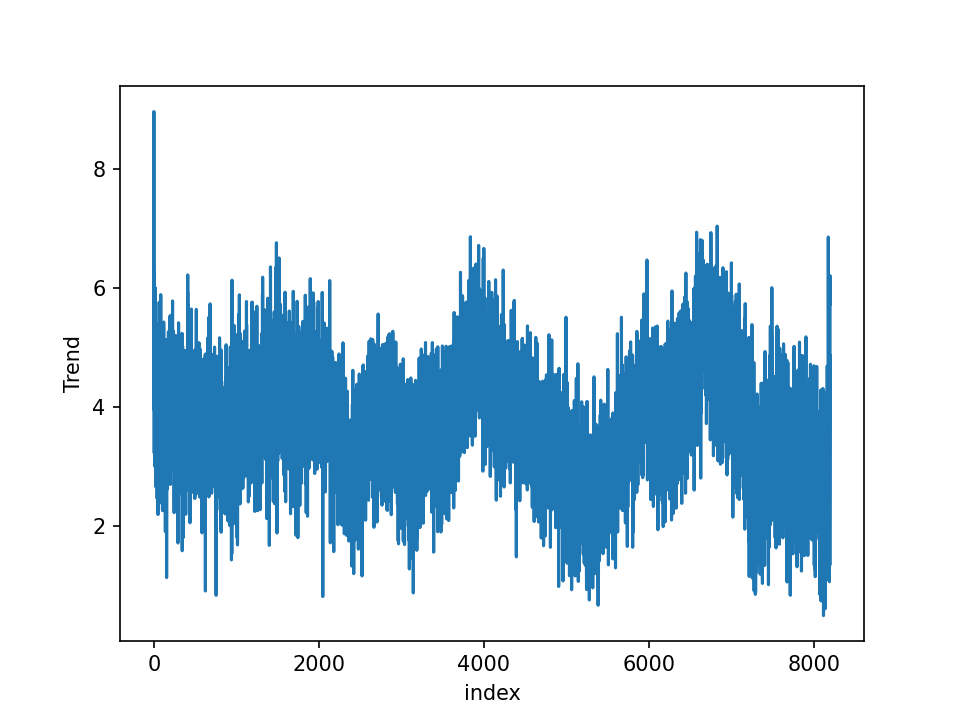

In [119]:
ds_test.Trend.plot()

<IPython.core.display.Javascript object>


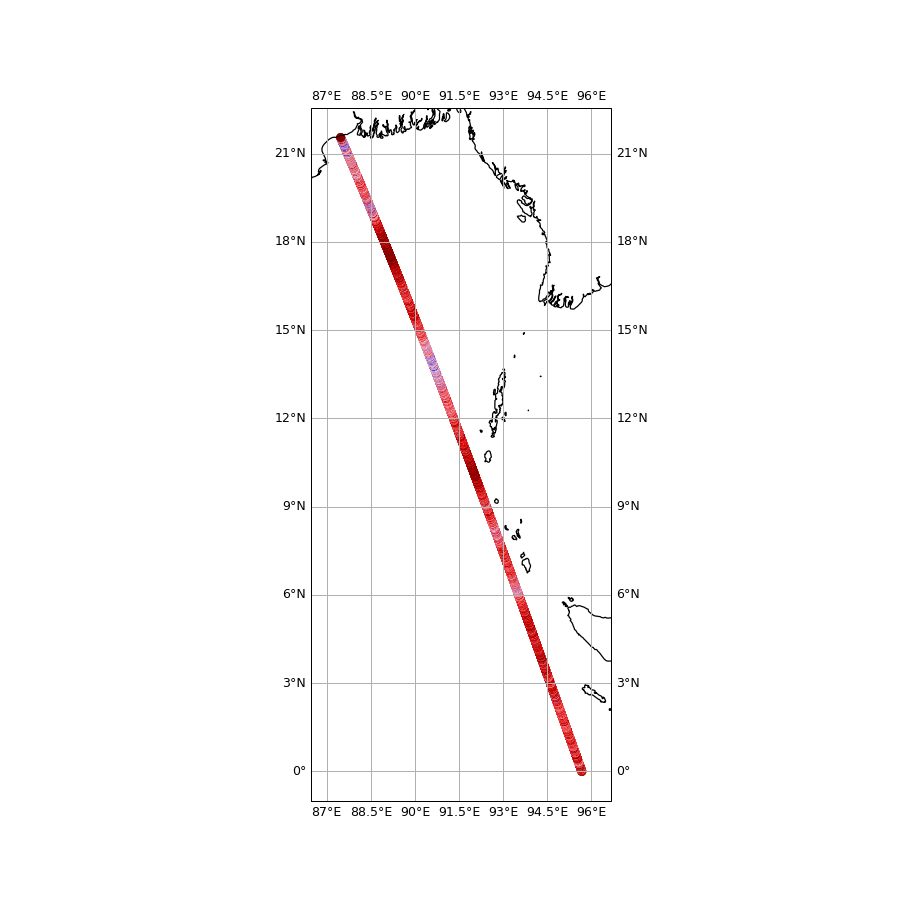

In [59]:
dl=1.
extent = [ds_test.lon.min()-dl, ds_test.lon.max()+dl, ds_test.lat.min()-dl, ds_test.lat.max()+dl]
cmap_trend = plt.get_cmap('seismic')
fig=plt.figure(figsize=(10,10),dpi=60)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent(extent, ccrs.PlateCarree())
ax.scatter(ds_test.lon,ds_test.lat,c=ds_test.Trend,marker='o',cmap=cmap_trend,vmin=0,vmax=5)
ax.coastlines(resolution='10m') 
ax.gridlines(draw_labels=True)
plt.show()

<IPython.core.display.Javascript object>


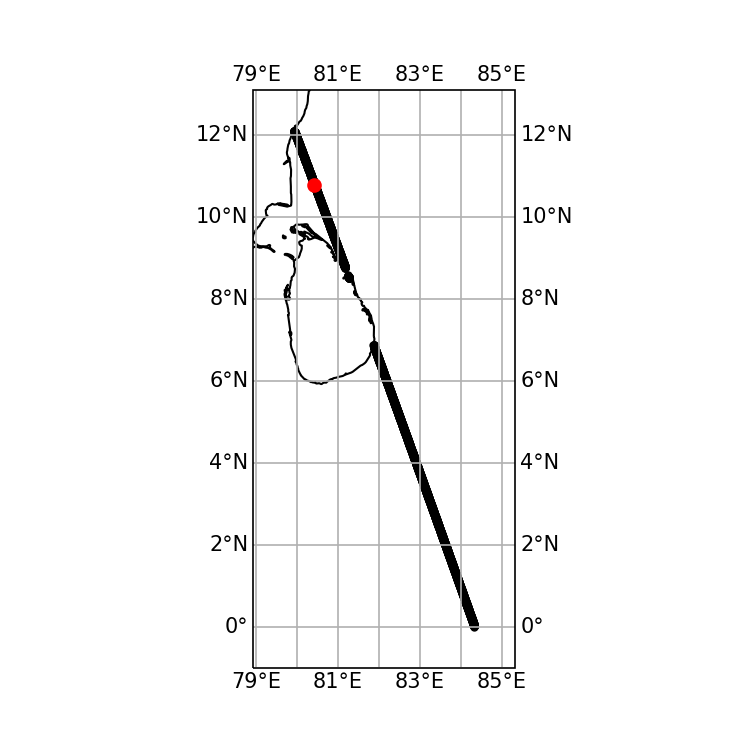

In [115]:
map_selected_point(ds,-500)